In [ ]:
%pip install scikit-survival

In [ ]:
%pip install pymc

In [ ]:
%pip install pymc-bart

In [ ]:
%pip install mlflow

In [4]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess

In [27]:
plt.ioff()
np.random.seed(99)

In [ ]:
# reload when changes to simsurv_func 
# importlib.reload(ssf)

# Objective
Simulations of the cox proportional and non proportional survial models. 
Validation of bart pymc against cph model, rsf model.

Validation metrics:
    2 bool
    5 bool
    2 bool + 1 linear
    complex combination

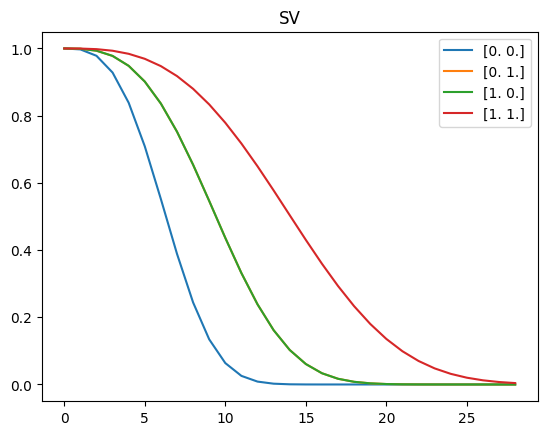

In [40]:
ALPHA = 3
# ALPHA_F = "1 + (1.5 * x_mat[:,0]) + x_mat[:,1]"
LAMBDA = "np.exp(2 + 0.4*(x_mat[:,0] + x_mat[:,1]))"
# LAMBDA = "np.exp(1 + .2*x_mat[:,0] + .3*x_mat[:,1] + 0.8*np.sin(x_mat[:,0] * x_mat[:,1]) + np.power((x_mat[:,2] - 0.5),2))"
# TRAIN_CSV = "outputs/train.csv"
# RBART_CSV = "outputs/rbart_surv.csv"
N = 500
# T = 30
X_VARS = 2
CENS_IND = False
CENS_SCALE = 5

sv_mat, x_mat, lmbda, a, tlat, cens, t_event, status, T = ssf.sim_surv(
                N=N, 
                # T=T,
                x_vars=X_VARS,
                a = ALPHA,
                # alpha_f = ALPHA_F,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False)

x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
event_calc, cens_calc = ssf.get_status_perc(status)
t_mean, t_max = ssf.get_event_time_metric(t_event)
title="SV"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True)

In [41]:
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
event_calc, cens_calc = ssf.get_status_perc(status)
t_mean, t_max = ssf.get_event_time_metric(t_event)
train = ssf.get_train_matrix(x_mat, t_event, status)
y_sk = ssf.get_y_sklearn(status, t_event)
x_sk = train.iloc[:,2:]

In [36]:
# plt.hist(train.time, train.status)
def get_event_plot(train):
    fig = plt.figure()
    plt.hist(train.time[train.status==1], rwidth=.5, label="event")
    plt.hist(train.time[train.status==0], rwidth=.5, label = "cens")
    plt.xticks(np.arange(1,train.time.max()+1,2))
    plt.legend()
    plt.close(fig)
    return fig

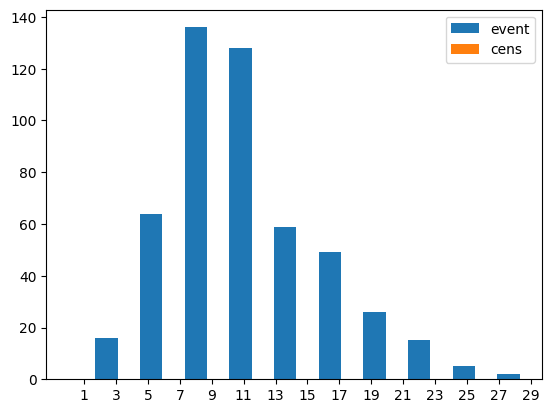

In [42]:
fig = get_event_plot(train)
fig

In [ ]:
# Set experiment
    # - each simulation parms is a new experiment

try:
    ml.create_experiment(name = "test_sim")
except:
    ml.set_experiment("test_sim")

# Simulation loop

    # Creat run
with ml.start_run(run_name="test6") as run:
    run_info = ml.active_run()
    OUTPUTS = "outputs"
    ALPHA = 3
    ALPHA_F = "1 + (1.5 * x_mat[:,0]) + x_mat[:,1]"
    # LAMBDA = "np.exp(2 + 0.4*(x_mat[:,0] + x_mat[:,1]))"
    LAMBDA = "np.exp(1 + .2*x_mat[:,0] + .3*x_mat[:,1] + 0.8*np.sin(x_mat[:,0] * x_mat[:,1]) + np.power((x_mat[:,2] - 0.5),2))"
    TRAIN_CSV = "outputs/train.csv"
    RBART_CSV = "outputs/rbart_surv.csv"
    N = 500
    # T = 30
    X_VARS = 5
    CENS_IND = False
    CENS_SCALE = 60

    ###########################################################################
    # Simulate data
    sv_mat, x_mat, lmbda, a, tlat, cens, t_event, status, T = ssf.sim_surv(
                    N=N, 
                    # T=T,
                    x_vars=X_VARS,
                    a = ALPHA,
                    alpha_f = ALPHA_F,
                    lambda_f = LAMBDA,
                    cens_scale=CENS_SCALE,
                    cens_ind = CENS_IND,
                    err_ind = False)

    # log param alpha
    ml.log_param("alpha", ALPHA)
    # log param labmda
    ml.log_param("lambda", LAMBDA)
    # log param N
    ml.log_param("N", N)
    # log param T (# timepoint probabilites generated)
    ml.log_param("T", T)
    # log param X_VARS
    ml.log_param("X_VARS", X_VARS)
    # log parm CENS_SCALE
    ml.log_param("CENS_SCALE", CENS_SCALE)
    # log parm CENS_IND
    ml.log_param("CENS_IND", CENS_IND)
  
    # log param x_info
    x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
    try:
        ml.log_param("X_INFO", str(list(zip(x_out, x_cnt))))
    except:
        print("error")

    # log metric cen percent calculated
    # log metric status event calculated
    event_calc, cens_calc = ssf.get_status_perc(status)
    ml.log_metric("EVENT_PERC", event_calc)
    ml.log_metric("CENS_PERC", cens_calc)

    # log metric t_event mean
    # log metric t_event max
    t_mean, t_max = ssf.get_event_time_metric(t_event)
    ml.log_metric("T_EVENT_MEAN", t_mean)
    ml.log_metric("T_EVENT_MAX", t_max)
    
    # log artif train dataset
    train = ssf.get_train_matrix(x_mat, t_event, status)
    # train.to_csv("outputs/train.csv")
    train.to_csv(TRAIN_CSV)
    ml.log_artifact("outputs/train.csv")
    
    # log artif plot curves
    title = "actual_survival"
    ssf.plot_sv(x_mat, sv_mat, T, title=title, save = True, dir=OUTPUTS)
    ml.log_artifact(f"{OUTPUTS}/{title}.png")
    

    # get sklearn components
    y_sk = ssf.get_y_sklearn(status, t_event)
    x_sk = train.iloc[:,2:]

    ######################################################################################
    # model cph
    cph = sksurv.linear_model.CoxPHSurvivalAnalysis()
    cph.fit(x_sk, y_sk)
    # log metri coeff
    for i in np.arange(len(cph.coef_)):
        ml.log_metric(f"cph_coef_{i}", cph.coef_[i])
        # log metri exp(coef)
        ml.log_metric(f"cph_exp_coef_{i}", np.exp(cph.coef_[i]))
    # predic cph
    cph_surv = cph.predict_survival_function(pd.DataFrame(x_out))

    # get plotable data
    # cph_sv_val = [sf(np.arange(T)) for sf in cph_surv]
    cph_sv_t = cph_surv[0].x
    cph_sv_val = [sf(cph_sv_t) for sf in cph_surv]
    cph_sv_t = np.concatenate([np.array([0]), cph_sv_t])
    cph_sv_val = [np.concatenate([np.array([1]), sv]) for sv in cph_sv_val]

    # log artif plot curves
    title = "cph_surv_pred"
    ssf.plot_sv(x_mat, cph_sv_val, t=cph_sv_t, title = title, save=True, dir="outputs")
    ml.log_artifact(f"outputs/{title}.png")
    # log model cph
    # idk how to do
    
    ###################################################################################
    #  model rsf
    rsf = sksurv.ensemble.RandomSurvivalForest(
        n_estimators=1000, min_samples_split=100, min_samples_leaf=15, n_jobs=-1, random_state=20
    )
    rsf.fit(x_sk, y_sk)
    # predict rsf
    rsf_surv = rsf.predict_survival_function(pd.DataFrame(x_out))
    # get plotable predictions
    # rsf_sv_val = [sf(np.arange(T)) for sf in rsf_surv]
    rsf_sv_t = rsf_surv[0].x
    rsf_sv_val = [sf(rsf_sv_t) for sf in rsf_surv]
    rsf_sv_t = np.concatenate([np.array([0]), rsf_sv_t])
    rsf_sv_val = [np.concatenate([np.array([1]), sv]) for sv in rsf_sv_val]
    # log artif plot curves
    title = "rsf_surv_pred"
    ssf.plot_sv(x_mat, rsf_sv_val, t=rsf_sv_t, title=title, save=True, dir="outputs")
    ml.log_artifact(f"outputs/{title}.png")
    # log model resf

    ################################################################################
    # BART
    M = 200 # number of trees
    DRAWS = 200
    TUNE = 200
    CORES = 4
    ml.log_param("n_tree", M)
    ml.log_param("draws", DRAWS)
    ml.log_param("tune", TUNE)

    # tranform data long-form
    b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk)
    # b_te_t, b_te_x = surv_pre_test(x_sk, y_sk)
    b_te_x = ssf.get_bart_test(x_out, np.unique(b_tr_t))
    off = sp.norm.ppf(np.mean(b_tr_delta))
    # model bart
  
    with pm.Model() as bart:
        x_data = pm.MutableData("x", b_tr_x)
        f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M)
        z = pm.Deterministic("z", f + off)
        mu = pm.Deterministic("mu", pm.math.invprobit(z))
        y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
        bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)

    with bart:
    # pm.set_data({"x":pd.DataFrame(test_x), "off":off_test})
        pm.set_data({"x":pd.DataFrame(b_te_x)})
        pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])
    
    # transform to survival
    bart_sv_fx = ssf.get_sv_fx(pp, x_out)
    # bart_svt
    bart_sv_t = np.unique(b_tr_t)

    # add a time 0 with prob 1 
    bart_sv_t = np.concatenate([np.array([0]), bart_sv_t])
    bart_sv_val = [np.concatenate([np.array([1]), sv]) for sv in bart_sv_fx]
    
    # log artif plot curves
    title = "bart_surv_pred"
    ssf.plot_sv(x_mat, bart_sv_val, t=bart_sv_t, title=title, save=True, dir="outputs")
    ml.log_artifact(f"outputs/{title}.png")
    # log model bart /idk how to do

    # get metrics rmse, bias
    rsf_rmse, rsf_bias, t_quant = ssf.get_metrics( f_t = rsf_sv_val, f = sv_mat[x_idx], T = rsf_sv_t[rsf_sv_t <T])

    cph_rmse, cph_bias, t_quant = ssf.get_metrics( f_t = cph_sv_val, f = sv_mat[x_idx], T = cph_sv_t[cph_sv_t < T])

    bart_rmse, bart_bias, t_quant = ssf.get_metrics(f_t = bart_sv_val, f = sv_mat[x_idx], T = bart_sv_t[bart_sv_t < T])

    # log metri cph_rmse
    # log metri cph_bias
    # log metri rsf_rmse
    # log metri rsf_bias
    # log metri bart_rmse
    # log metri bart_bias
    for i in np.arange(rsf_rmse.shape[1]):
        ml.log_metric(f"rmse_rsf_{i}", rsf_rmse[0,i])
        ml.log_metric(f"rmse_cph_{i}", cph_rmse[0,i])
        ml.log_metric(f"rmse_bart_{i}", bart_rmse[0,i])
        ml.log_metric(f"bias_rsf_{i}", rsf_bias[0,i])
        ml.log_metric(f"bias_cph_{i}", cph_bias[0,i])
        ml.log_metric(f"bias_bart_{i}", bart_bias[0,i])

    ############################################################################
    # run the rbart subprocess
    p1 = subprocess.Popen([
        "Rscript",
        "surv_sim_function.R",
        TRAIN_CSV,
        RBART_CSV
        ])
    p1.wait()

    # get Rbart data
    rb_mat, rb_x, rb_idx, rb_sv_t, rb_sv_val = ssf.get_rbart_data(RBART_CSV)
    # get survival plot
    title = "rbart_surv_pred"
    ssf.plot_sv(rb_mat, rb_sv_val, t=rb_sv_t, title=title, show = False, save=True, dir="outputs")
    ml.log_artifact(f"outputs/{title}.png")

    # get metrics for rb
    rb_rmse, rb_bias, t_quant = ssf.get_metrics( f_t = rb_sv_val, f = sv_mat[x_idx], T = rb_sv_t)

    # log metrics
    for i in np.arange(rb_rmse.shape[1]):
        ml.log_metric(f"rmse_rb_{i}", rb_rmse[0,i])
        ml.log_metric(f"bias_rb_{i}", rb_bias[0,i])


    # log mean metrics for all
    ml.log_metric("rmse_mean_cph", cph_rmse.mean())
    ml.log_metric("bias_mean_cph", cph_bias.mean())
    ml.log_metric("rmse_mean_rsf", rsf_rmse.mean())
    ml.log_metric("bias_mean_rsf", rsf_bias.mean())
    ml.log_metric("rmse_mean_bart", bart_rmse.mean())
    ml.log_metric("bias_mean_bart", bart_bias.mean())
    ml.log_metric("rmse_mean_rb", rb_rmse.mean())
    ml.log_metric("bias_mean_rb", rb_bias.mean())


    # log all plots of metrics
    title="RMSE"
    ssf.plot_metrics(t_quant, T, rsf_rmse[0], cph_rmse[0], bart_rmse[0], rb_rmse[0], title, "outputs")
    ml.log_artifact(f"outputs/{title}.png")
    title="BIAS"
    ssf.plot_metrics(t_quant, T, rsf_bias[0], cph_bias[0], bart_bias[0], rb_bias[0], title, "outputs")
    ml.log_artifact(f"outputs/{title}.png")
    
# End run (defaults when using with/ block)

